# RL and Advanced DL: Домашнее задание 2

## Часть 2: добавим нейронных сетей

Студент Черников Дмитрий, ML-32

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import copy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict, Counter, deque
from itertools import count

from tictactoe import TicTacToe

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
def run_episode(env, pi1, pi2, n_rows=3, n_cols=3, n_win=3, verbose=False):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    env.reset()
    n_actions = n_rows*n_cols
    state = env.board.flatten()
    state_pi1 = env.board.flatten()
    state_pi2 = env.board.flatten()
    actions, reward, done = env.getEmptySpaces(), 0, False
    while not done:
        turn = env.curTurn
        actions_idx = [env.int_from_action(a) for a in actions]
        
        if turn == 1:
            idx = pi1.action(state, actions_idx)
        else:
            idx = pi2.action(state, actions_idx)
            
        action = env.action_from_int(idx)
        (next_state, actions, _), reward, done, _ = env.step(action)
        next_state = env.board.flatten()

        if turn == 1:
            pi1.update(state, idx, reward, next_state, done)
            pi2.update(state, n_actions, -100, next_state, done)
        else:
            pi1.update(state, n_actions, -100, next_state, done)
            pi2.update(state, idx, -1 * reward, next_state, done)

        state = next_state
        
        if verbose:
            env.printBoard()
        
    if verbose:
        if reward == 1:
            print("Крестики выиграли!")
        if reward == -1:
            print("Нолики выиграли!")
        if reward == 0:
            print("Ничья!")
    return reward, env


def run_initialization(pi1, pi2, n_rows=3, n_cols=3, n_win=3, n_iters=1000, verbose=False):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    n_actions = n_rows * n_cols
    loss_history = []
    for _ in range(n_iters):
        env.reset()
        env.board.flatten()
        state = env.board.flatten()
        state_pi1 = env.board.flatten()
        state_pi2 = env.board.flatten()
        actions, reward, done = env.getEmptySpaces(), 0, False
        while not done:
            turn = env.curTurn
            a = np.random.randint(0, len(actions))
            idx = env.int_from_action(actions[a])
            (_, actions, _), reward, done, _ = env.step(actions[a])
            next_state = env.board.flatten()
            
            if turn == 1:
                pi1.update(state, idx, reward, next_state, done)
                pi2.update(state, n_actions, -100, next_state, done)
            else:
                pi1.update(state, n_actions, -100, next_state, done)
                pi2.update(state, idx, -1 * reward, next_state, done)
                
            state = next_state
        
def run_series(pi1, pi2, n_rows=3, n_cols=3, n_win=3, n_iters=1000, verbose=False):
    results = []
    for i in range(n_iters):
        env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        reward, env = run_episode(env, pi1, pi2, n_rows, n_cols, n_win, verbose=verbose)
        results.append(reward)
    return np.array(results)

        
def plot_series_results(results, width=0.1, label=None):
    x = Counter(results)
    s = np.sum(list(x.values()))
    plt.bar(x.keys(), [v/s for v in x.values()], width=width, label=label)
    plt.xticks(ticks=[-1, 0, 1], labels=["Нолик", "Ничья", "Крестик"])
    if label is not None:
        plt.legend()

In [4]:
class RandomPolicy():
    def __init__(self, name=""):
        self.name = name
        self.buffer = deque(maxlen=int(10))
        
    def action(self, state, actions):
        return np.random.choice(actions)
    
    def collect(self, state, action, reward, next_state, done):
        pass
    
    def update(self, state, action, reward, next_state, done):
        pass

## 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
GAMMA = 0.95
BATCH_SIZE = 256
UPDATE_STEPS = 32
LEARNING_RATE = 5e-4
HIDDEN_DIM = 256

class DQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, eps=0.95, device="cpu"):
        self.steps = 1
        self.rands = 0
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.eps = eps
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(n_rows*n_cols, 2*HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(2*HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(), 
            nn.Linear(HIDDEN_DIM, n_rows*n_cols + 1)
        ).to(self.device)
        self.target_model = copy.deepcopy(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), LEARNING_RATE)
        self.buffer = deque(maxlen=int(1e6))

    def sample_batch(self):
        batch_idx = np.random.randint(0, len(self.buffer) - 1, BATCH_SIZE)
        returns = []
        for i in range(5):
            batch = torch.from_numpy(
                np.array([self.buffer[idx][i] for idx in batch_idx], dtype=np.float32)
            ).to(self.device)
            returns.append(batch)
        return returns
        
    def train_step(self, batch):
        state, action, reward, next_state, done = batch

        action = action.reshape(-1, 1)
        reward = reward.reshape(-1, 1)
        done = done.reshape(-1, 1)

        with torch.no_grad():
            target_q = self.target_model(next_state)
            target_q = torch.max(target_q, dim=1).values.reshape(-1,1)
            target_q = reward + GAMMA * (1 - done)
        
        q = self.model(state).gather(1, action.long())
        
        loss = F.mse_loss(q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def action(self, state, actions):
        if np.random.uniform() < self.eps:
            state = torch.tensor(np.array(state)).float().to(self.device)
            with torch.no_grad():
                pred = self.model(state).cpu().numpy()
            idx = pred[actions].argmax()
            return actions[idx]
        self.rands += 1
        return np.random.choice(actions)

    def collect(self, state, a, reward, next_state, done):
        self.buffer.append((state, a, reward, next_state, done))
        
    def update(self, state, a, reward, next_state, done):
        self.collect(state, a, reward, next_state, done)
        if self.steps % UPDATE_STEPS == 0:
            batch = self.sample_batch()
            self.train_step(batch)
            self.update_target()
        self.steps += 1

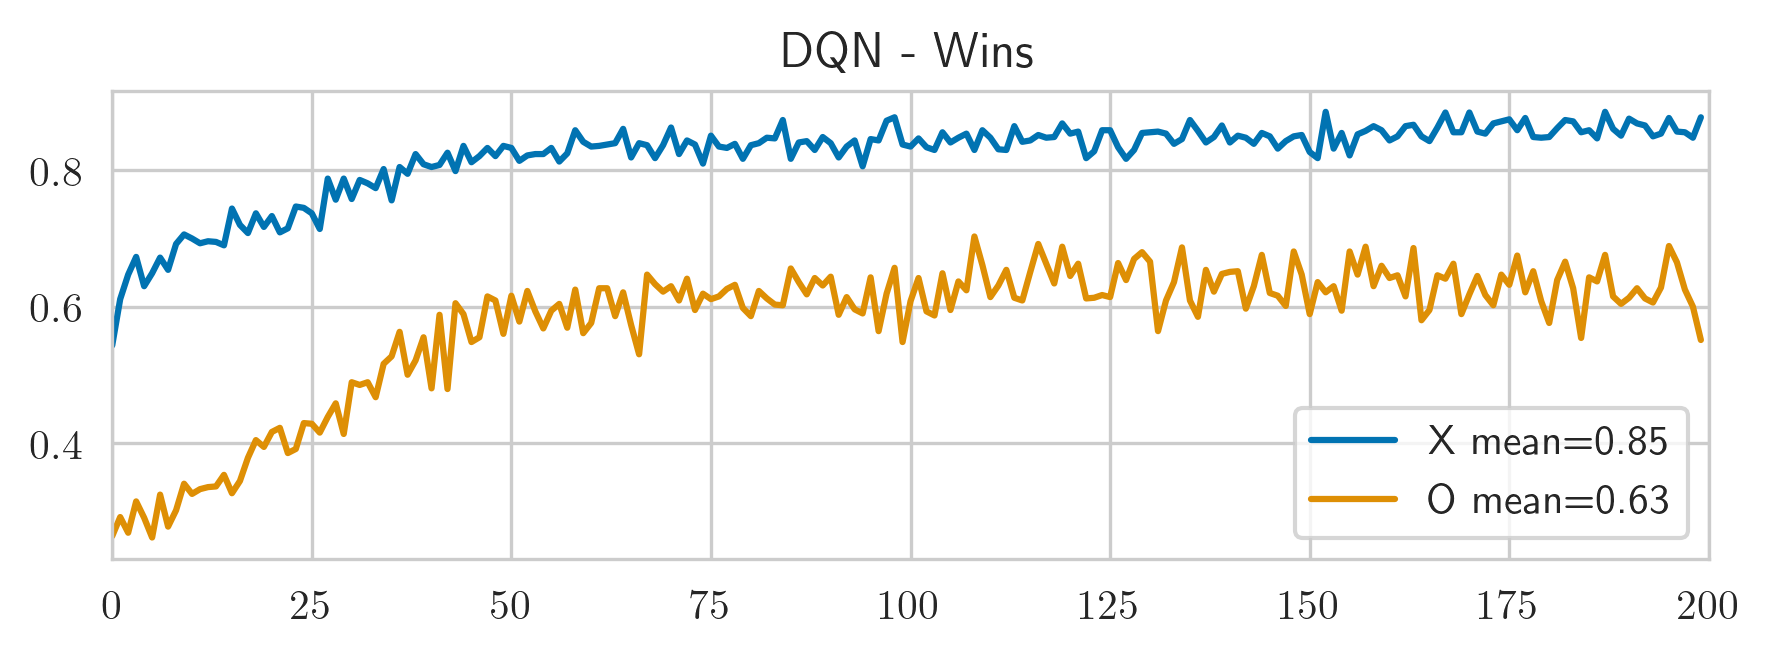

In [9]:
SEED = 10
N_WIN = 3
N_ROWS = 3
N_COLS = 3
INITIAL_STEPS = 1000
N_ITERS = 1000
N_EPOCHS = 200

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

piX = DQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(piX, RandomPolicy(), N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

piO = DQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(RandomPolicy(), piO, N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

historyX = []
historyO = []

plt.figure(figsize=(13,6))

for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piX, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyX.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piO, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyO.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 5 == 4:
        clear_output()
        
        plt.subplot(211)

        plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
        plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("DQN - Wins")
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()


clear_output()

plt.subplot(211)

plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
plt.xlim((0, N_EPOCHS))
plt.title("DQN - Wins")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

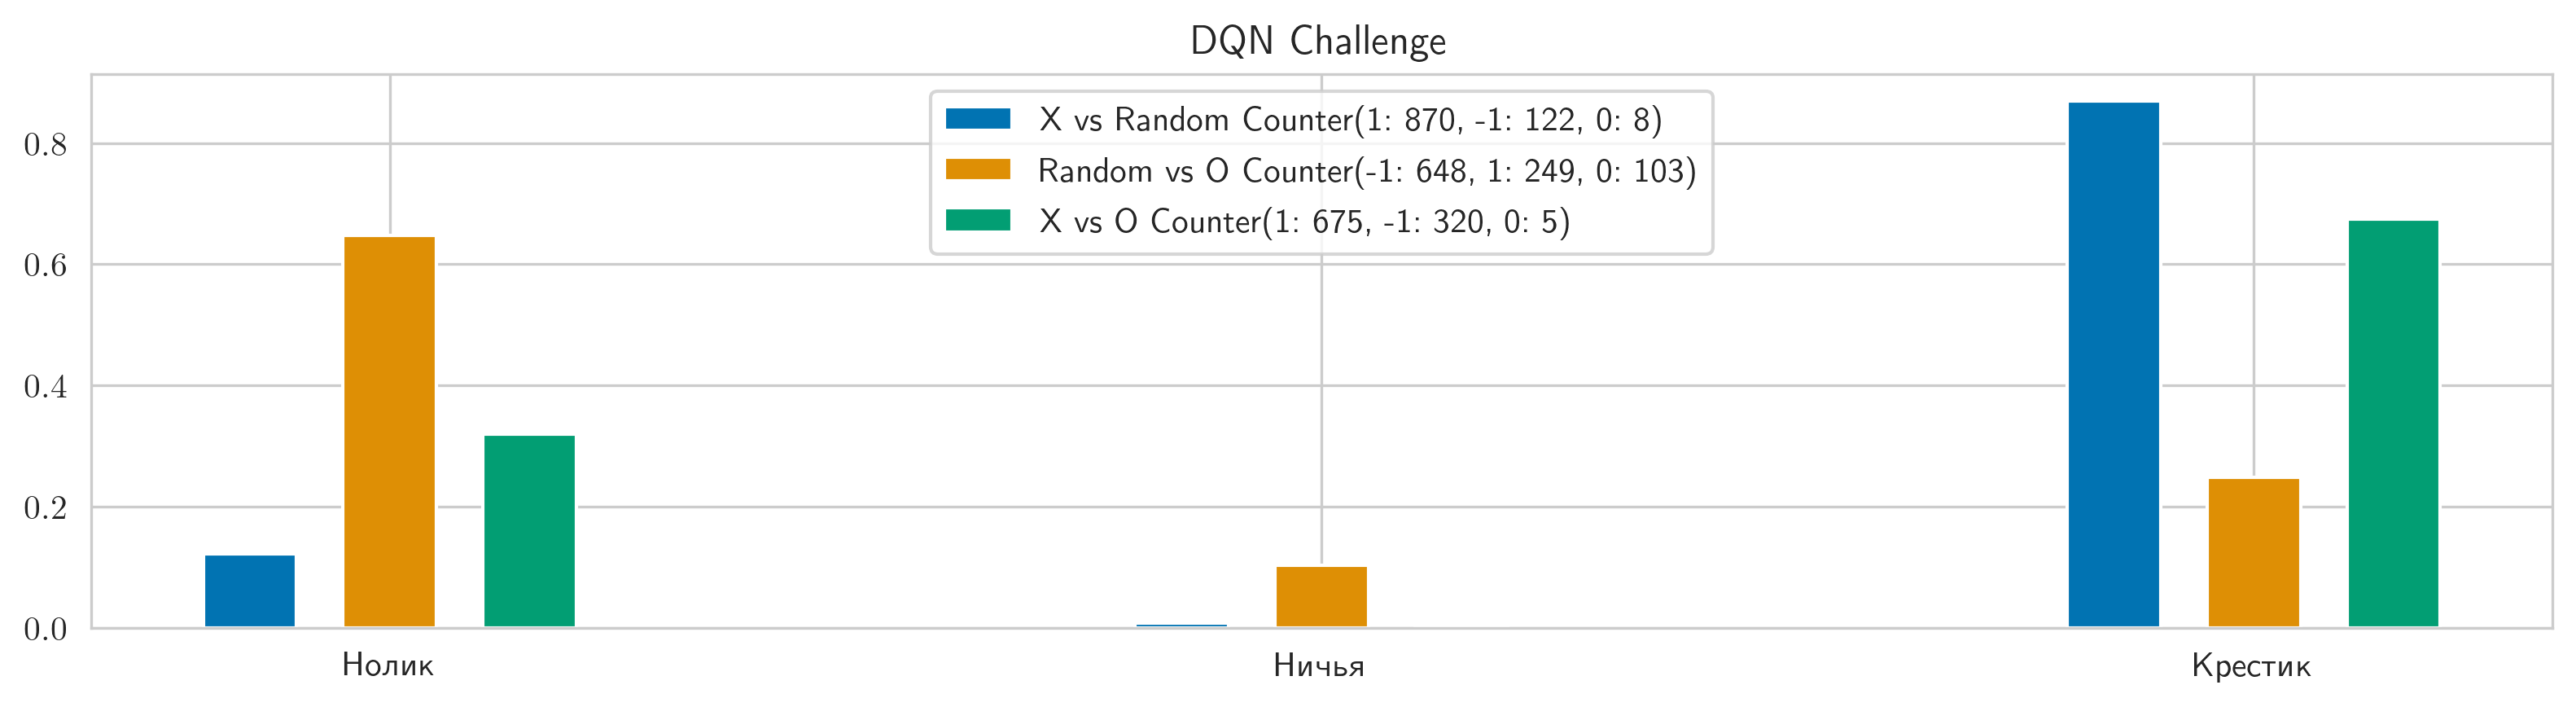

In [10]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piX, RandomPolicy())
plot_series_results(results-3/2*witdh, width=witdh, label=f"X vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piO)
plot_series_results(results, width=witdh, label=f"Random vs O {Counter(results)}")

results = run_series(piX, piO)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X vs O {Counter(results)}")

plt.legend(loc="upper center")
plt.title("DQN Challenge")
plt.show()

## 4. Double DQN

In [11]:
GAMMA = 0.99
BATCH_SIZE = 256
UPDATE_STEPS = 32
LEARNING_RATE = 5e-4
HIDDEN_DIM = 256

class DoubleDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, eps=0.95, device="cpu"):
        self.steps = 1
        self.rands = 0
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.eps = eps
        self.device = device
        self.model1 = nn.Sequential(
            nn.Linear(n_rows*n_cols, 2*HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(2*HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(), 
            nn.Linear(HIDDEN_DIM, n_rows*n_cols + 1)
        ).to(self.device)
        self.model2 = copy.deepcopy(self.model1)
        self.target_model = copy.deepcopy(self.model1)
        self.optimizer1 = optim.Adam(self.model1.parameters(), LEARNING_RATE)
        self.optimizer2 = optim.Adam(self.model2.parameters(), LEARNING_RATE)
        self.buffer = deque(maxlen=int(1e6))
        self.loss = []

    def sample_batch(self):
        batch_idx = np.random.randint(0, len(self.buffer) - 1, BATCH_SIZE)
        returns = []
        for i in range(5):
            batch = torch.from_numpy(
                np.array([self.buffer[idx][i] for idx in batch_idx], dtype=np.float32)
            ).to(self.device)
            returns.append(batch)
        return returns
        
    def train_step(self, batch):
        state, action, reward, next_state, done = batch

        action = action.reshape(-1, 1)
        reward = reward.reshape(-1, 1)
        done = done.reshape(-1, 1)
        
        if np.random.uniform() < 0.5:
            modelA, modelB = self.model1, self.model2
        else:
            modelA, modelB = self.model2, self.model1

        with torch.no_grad():
            target_q = modelA(next_state)
            target_q = torch.max(target_q, dim=1).values.reshape(-1,1)
            target_q = reward + GAMMA * (1 - done)
        
        q = modelB(state).gather(1, action.long())
        
        loss = F.mse_loss(q, target_q)
        
        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()
        loss.backward()
        self.optimizer1.step()
        self.optimizer2.step()
        self.loss.append(loss.item())
        
    def update_target(self):
        if np.random.uniform() < 0.5:
            model = self.model1
        else:
            model = self.model2
        self.target_model.load_state_dict(model.state_dict())

    def action(self, state, actions):
        if np.random.uniform() < self.eps:
            state = torch.tensor(np.array(state)).float().to(self.device)
            if np.random.uniform() < 0.5:
                model = self.model1
            else:
                model = self.model2
            with torch.no_grad():
                pred = model(state).cpu().numpy()
            idx = pred[actions].argmax()
            return actions[idx]
        self.rands += 1
        return np.random.choice(actions)

    def collect(self, state, a, reward, next_state, done):
        self.buffer.append((state, a, reward, next_state, done))
        
    def update(self, state, a, reward, next_state, done):
        self.collect(state, a, reward, next_state, done)
        if self.steps % UPDATE_STEPS == 0:
            batch = self.sample_batch()
            self.train_step(batch)
            self.update_target()
        self.steps += 1

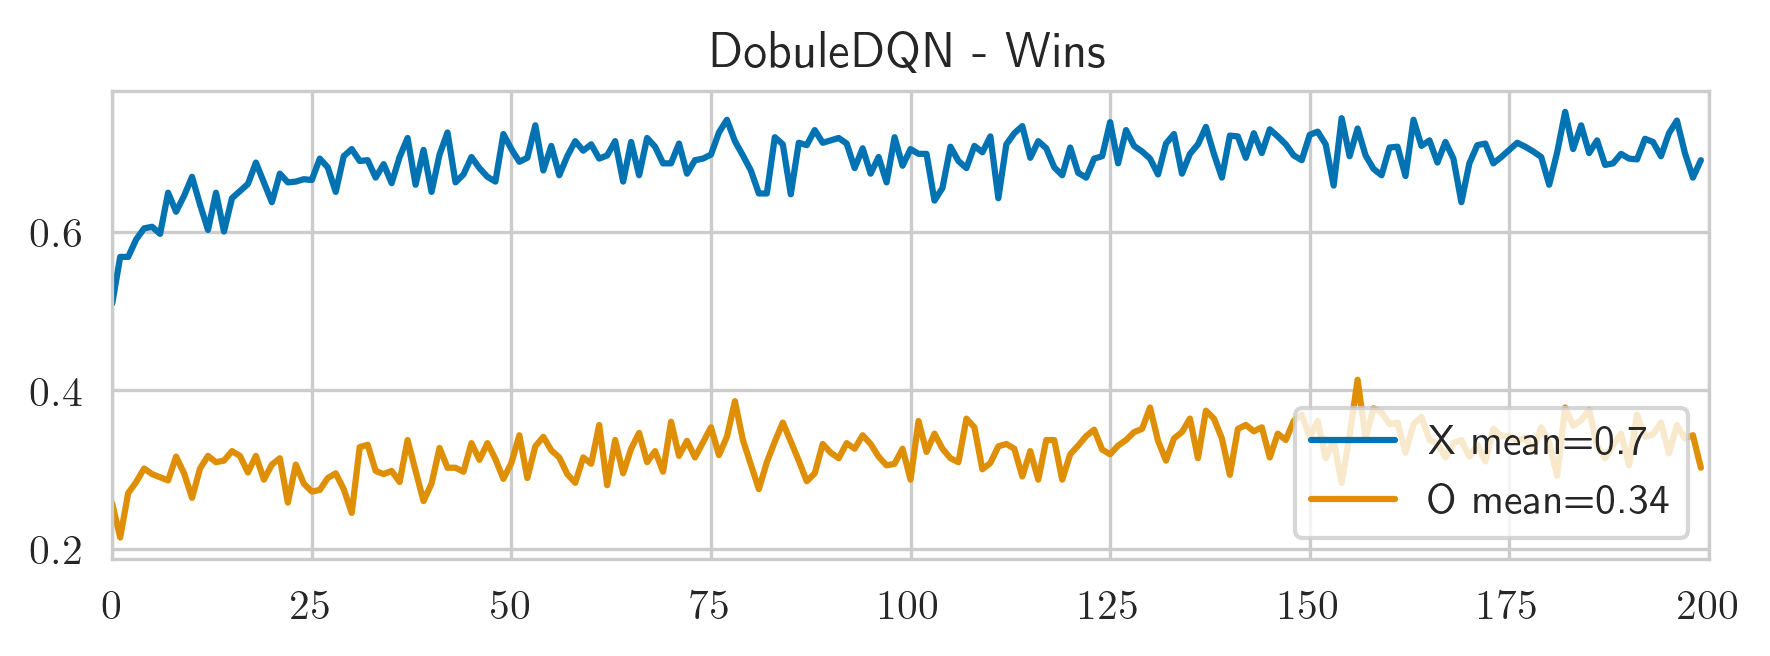

In [12]:
SEED = 10
N_WIN = 3
N_ROWS = 3
N_COLS = 3
INITIAL_STEPS = 1000
N_ITERS = 1000
N_EPOCHS = 200

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

piX2 = DoubleDQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(piX, RandomPolicy(), N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

piO2 = DoubleDQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(RandomPolicy(), piO, N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

historyX = []
historyO = []

plt.figure(figsize=(13,6))

for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piX2, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyX.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piO2, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyO.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 5 == 4:
        clear_output()
        
        plt.subplot(211)

        plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
        plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("DobuleDQN - Wins")
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()


clear_output()

plt.subplot(211)

plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
plt.xlim((0, N_EPOCHS))
plt.title("DobuleDQN - Wins")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

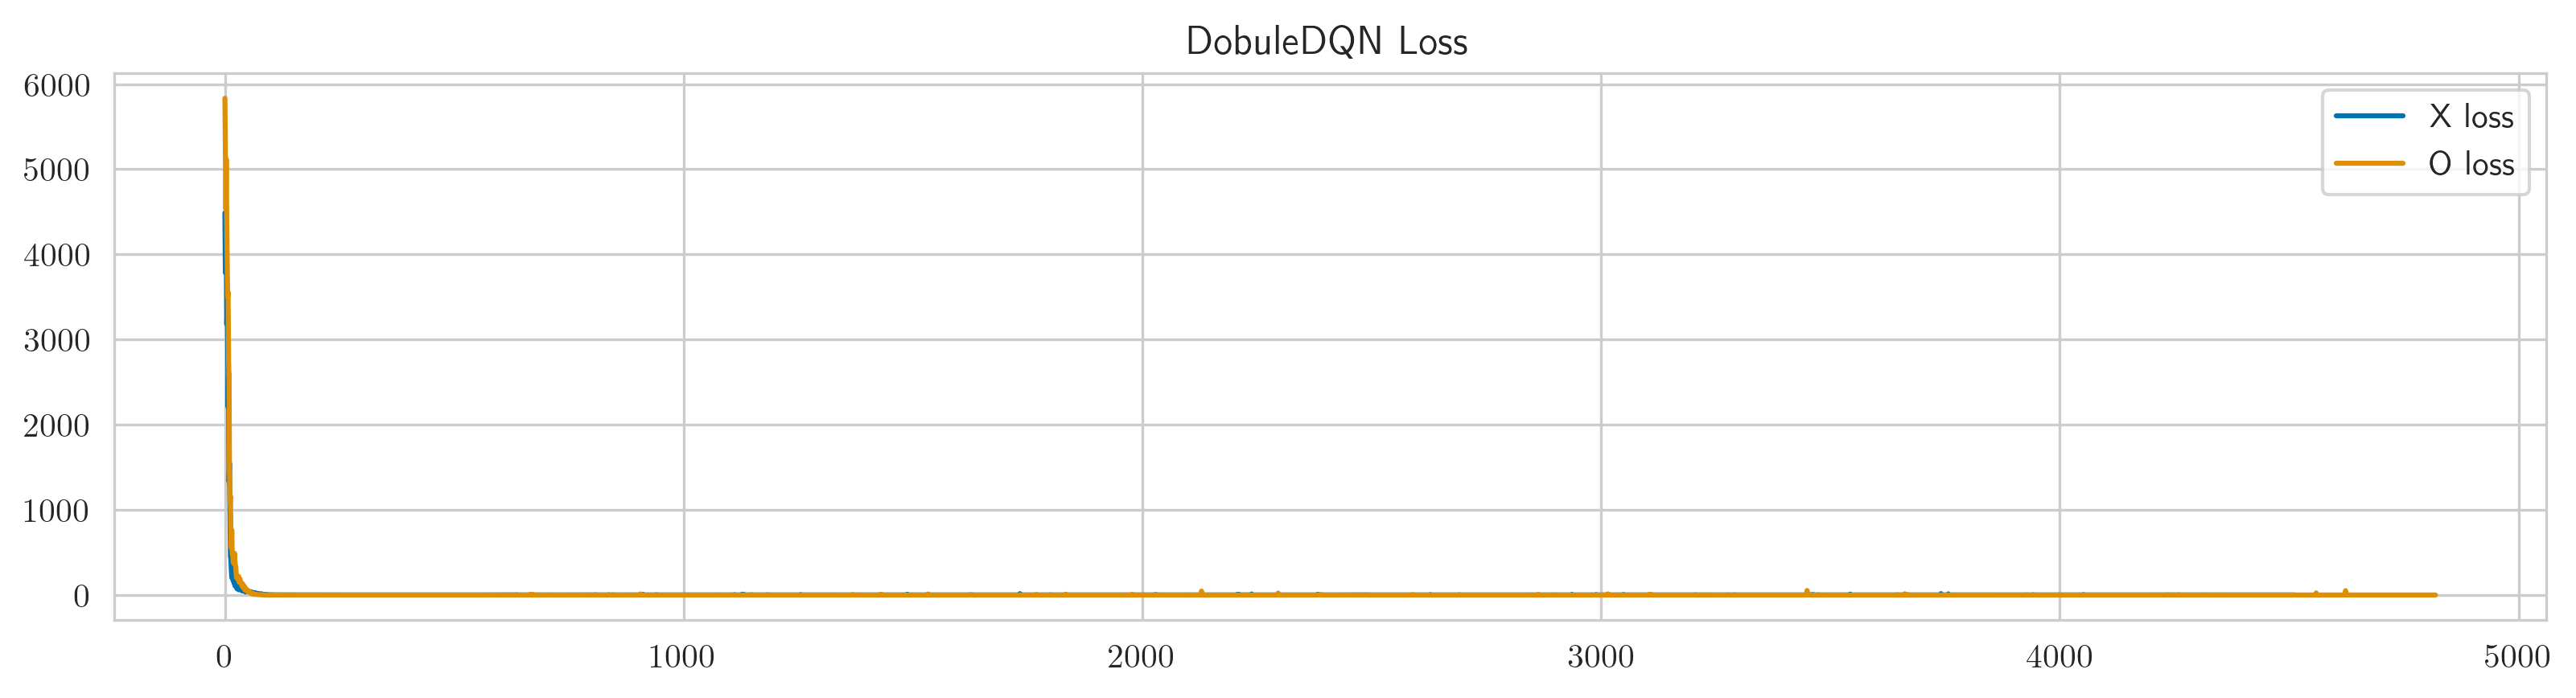

In [26]:
plt.figure(figsize=(13,3))       

plt.plot(piX2.loss[::10], label="X loss")
plt.plot(piO2.loss[::10], label="O loss")
plt.legend(loc="upper right")
plt.title("DobuleDQN Loss")
plt.show()

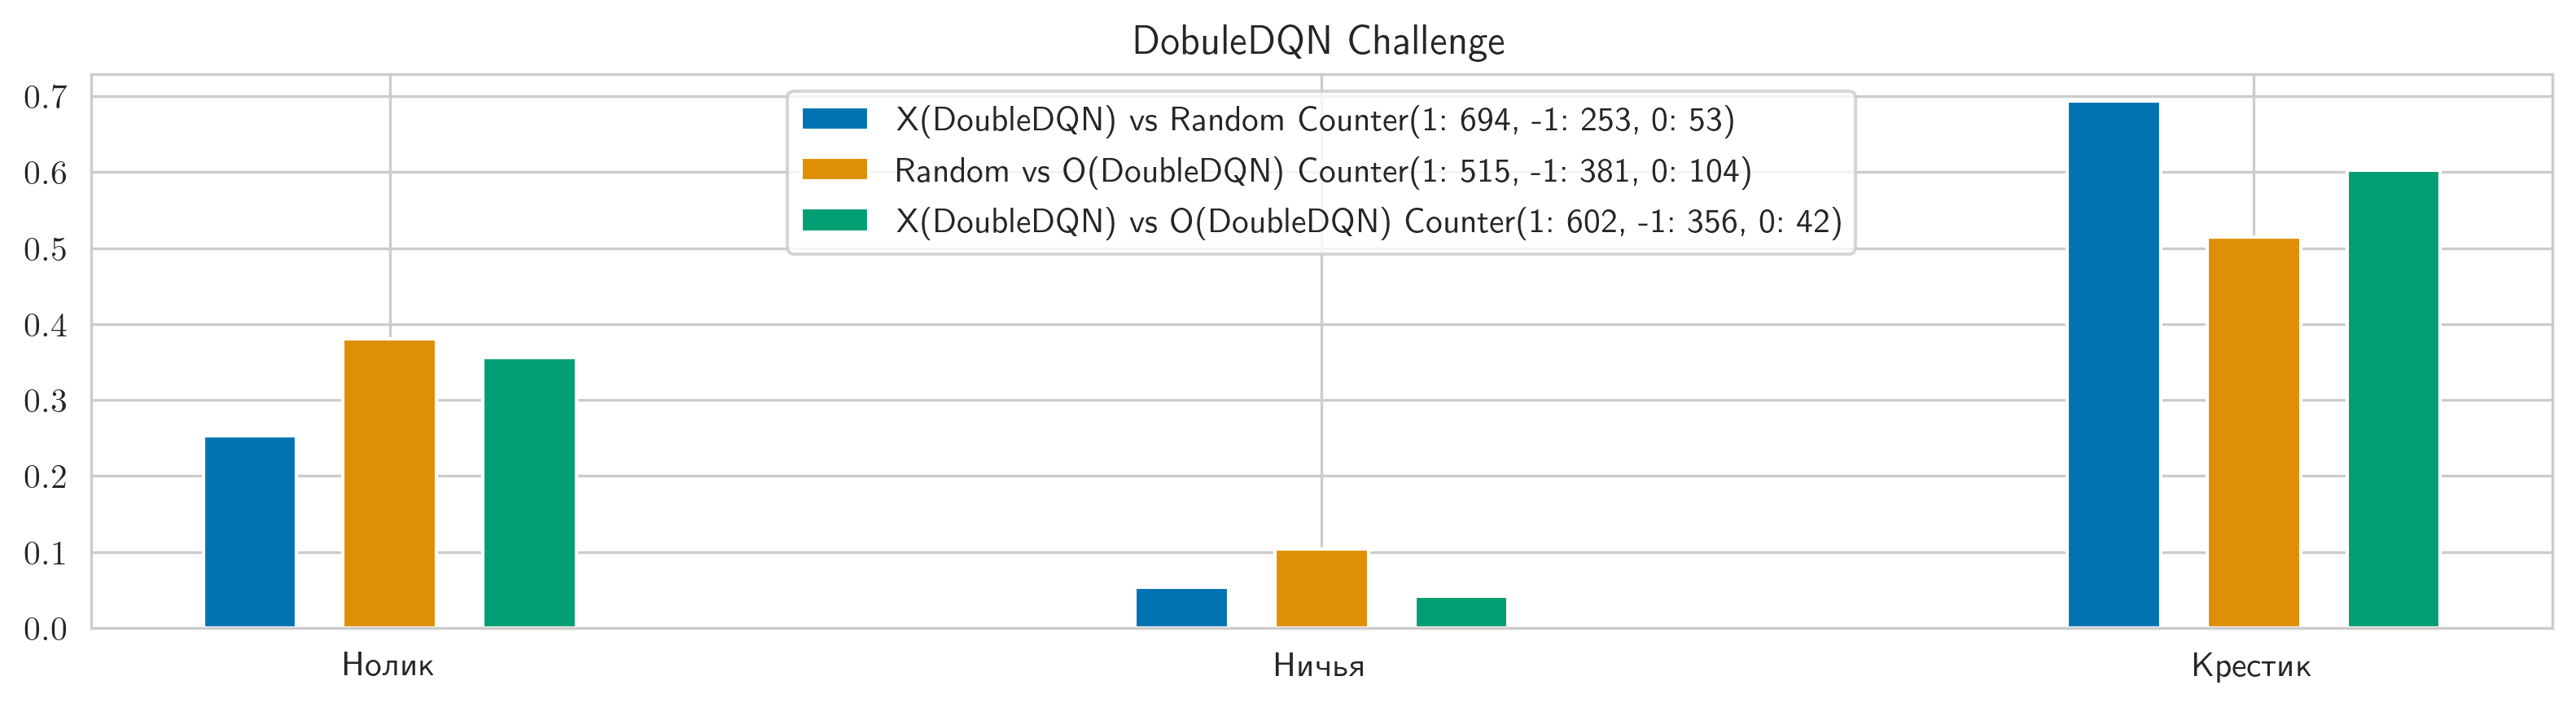

In [13]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piX2, RandomPolicy())
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(DoubleDQN) vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piO2)
plot_series_results(results, width=witdh, label=f"Random vs O(DoubleDQN) {Counter(results)}")

results = run_series(piX2, piO2)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(DoubleDQN) vs O(DoubleDQN) {Counter(results)}")

plt.legend(loc="upper center")
plt.title("DobuleDQN Challenge")
plt.show()

## 4. Dueling DQN

In [14]:
GAMMA = 0.99
BATCH_SIZE = 256
UPDATE_STEPS = 32
LEARNING_RATE = 5e-4
HIDDEN_DIM = 256

class DuelingDQNNet(nn.Module):
    def __init__(self, input_dim, output_dim, device):
        super(DuelingDQNNet, self).__init__()
        self.feauture_layer = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU()
        ).to(device)
        self.value_stream = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, 1)
        ).to(device)
        self.advantage_stream = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, output_dim)
        ).to(device)

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals
    
    
class DuelingDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, eps=0.95, device="cpu"):
        self.steps = 1
        self.rands = 0
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.eps = eps
        self.device = device
        self.model = DuelingDQNNet(n_rows*n_cols, n_rows*n_cols+1, device)
        self.target_model = copy.deepcopy(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), LEARNING_RATE)
        self.buffer = deque(maxlen=int(1e6))
        self.loss = []

    def sample_batch(self):
        batch_idx = np.random.randint(0, len(self.buffer) - 1, BATCH_SIZE)
        returns = []
        for i in range(5):
            batch = torch.from_numpy(
                np.array([self.buffer[idx][i] for idx in batch_idx], dtype=np.float32)
            ).to(self.device)
            returns.append(batch)
        return returns
        
    def train_step(self, batch):
        state, action, reward, next_state, done = batch

        action = action.reshape(-1, 1)
        reward = reward.reshape(-1, 1)
        done = done.reshape(-1, 1)
        
        with torch.no_grad():
            target_q = self.model(next_state)
            target_q = torch.max(target_q, dim=1).values.reshape(-1,1)
            target_q = reward + GAMMA * (1 - done)
        
        q = self.model(state).gather(1, action.long())
        
        loss = F.mse_loss(q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.loss.append(loss.item())
        
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def action(self, state, actions):
        if np.random.uniform() < self.eps:
            state = torch.tensor(np.array(state)).float().to(self.device)
            with torch.no_grad():
                pred = self.model(state).cpu().numpy()
            idx = pred[actions].argmax()
            return actions[idx]
        self.rands += 1
        return np.random.choice(actions)

    def collect(self, state, a, reward, next_state, done):
        self.buffer.append((state, a, reward, next_state, done))
        
    def update(self, state, a, reward, next_state, done):
        self.collect(state, a, reward, next_state, done)
        if self.steps % UPDATE_STEPS == 0:
            batch = self.sample_batch()
            self.train_step(batch)
            self.update_target()
        self.steps += 1

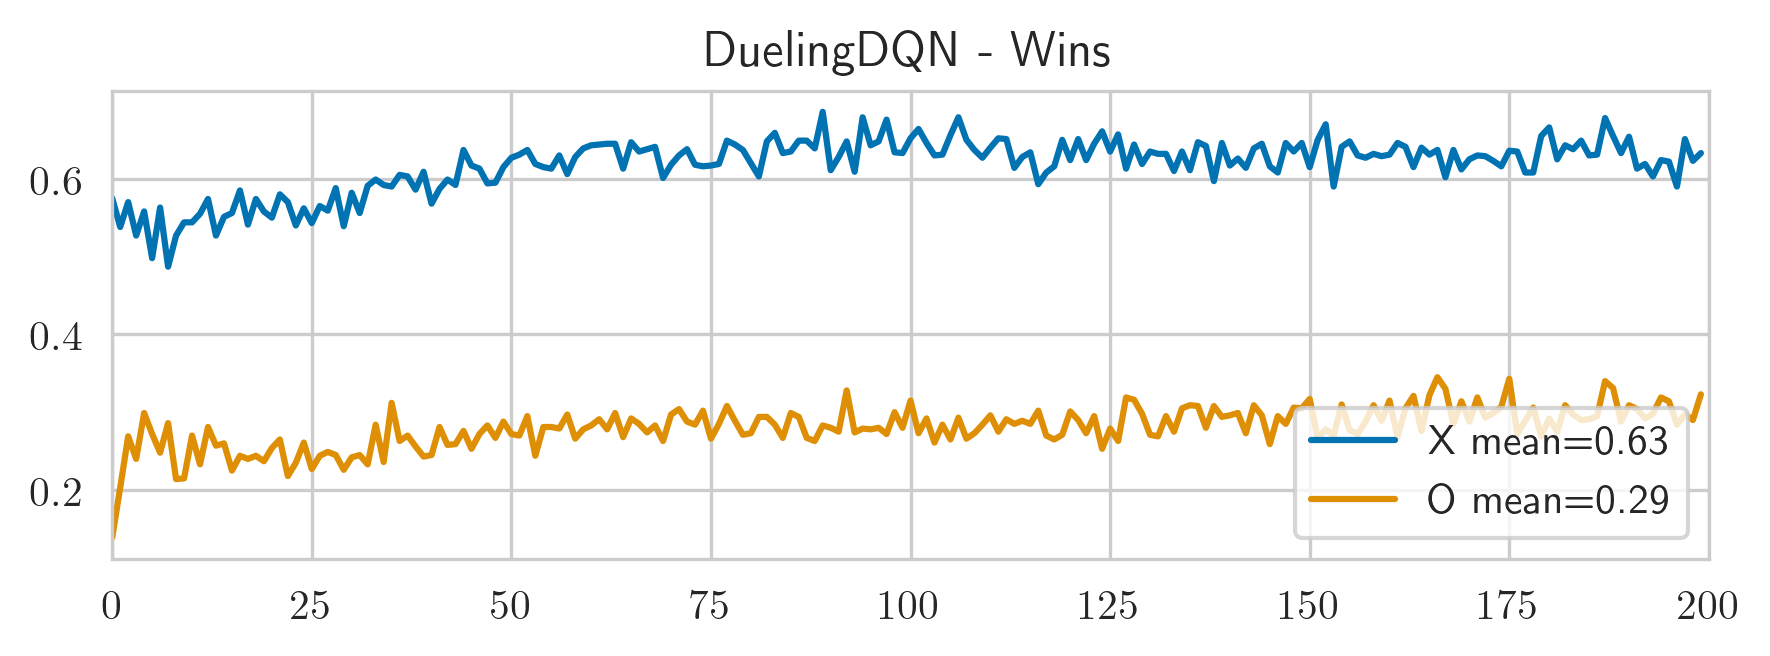

In [15]:
SEED = 10
N_WIN = 3
N_ROWS = 3
N_COLS = 3
INITIAL_STEPS = 1000
N_ITERS = 1000
N_EPOCHS = 200

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

piXd = DuelingDQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(piXd, RandomPolicy(), N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

piOd = DuelingDQN(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, device=DEVICE)
run_initialization(RandomPolicy(), piOd, N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

historyX = []
historyO = []

plt.figure(figsize=(13,6))

for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piXd, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyX.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piOd, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
    historyO.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 5 == 4:
        clear_output()
        plt.subplot(211)

        plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
        plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("DuelingDQN - Wins")
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()


clear_output()
plt.subplot(211)

plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
plt.xlim((0, N_EPOCHS))
plt.title("DuelingDQN - Wins")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

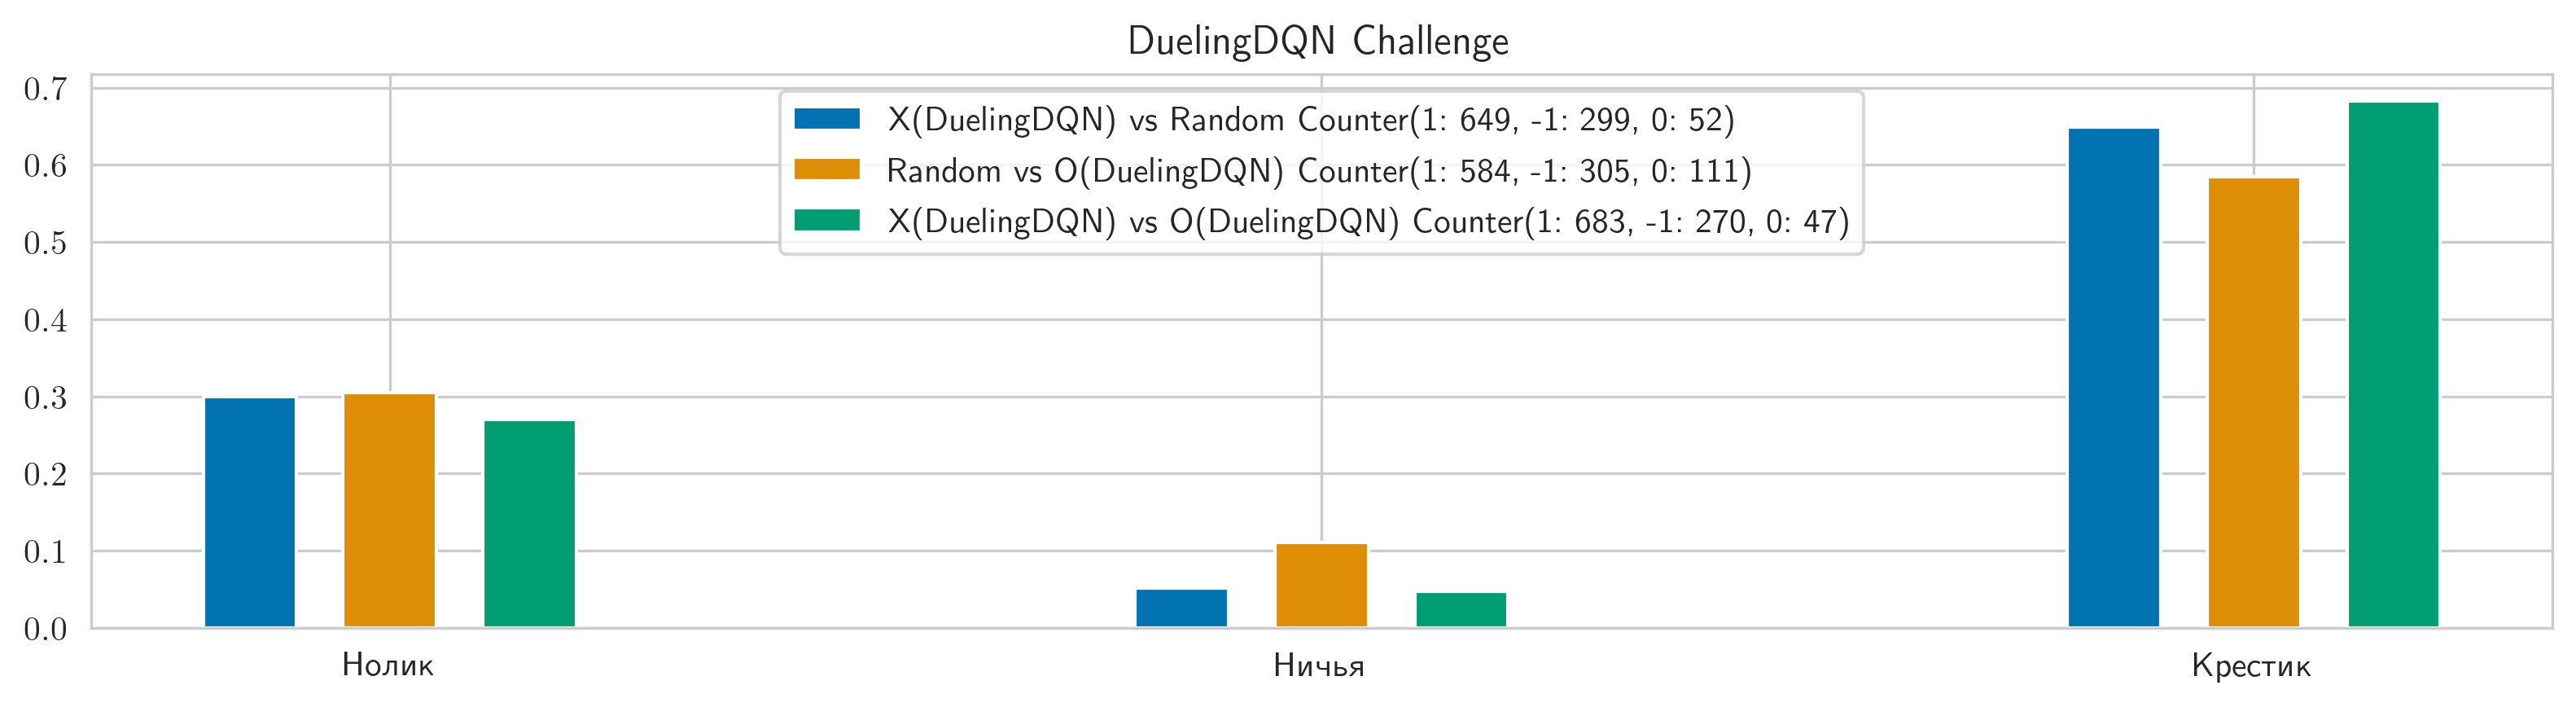

In [16]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piXd, RandomPolicy())
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(DuelingDQN) vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piOd)
plot_series_results(results, width=witdh, label=f"Random vs O(DuelingDQN) {Counter(results)}")

results = run_series(piXd, piOd)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(DuelingDQN) vs O(DuelingDQN) {Counter(results)}")

plt.legend(loc="upper center")
plt.title("DuelingDQN Challenge")
plt.show()

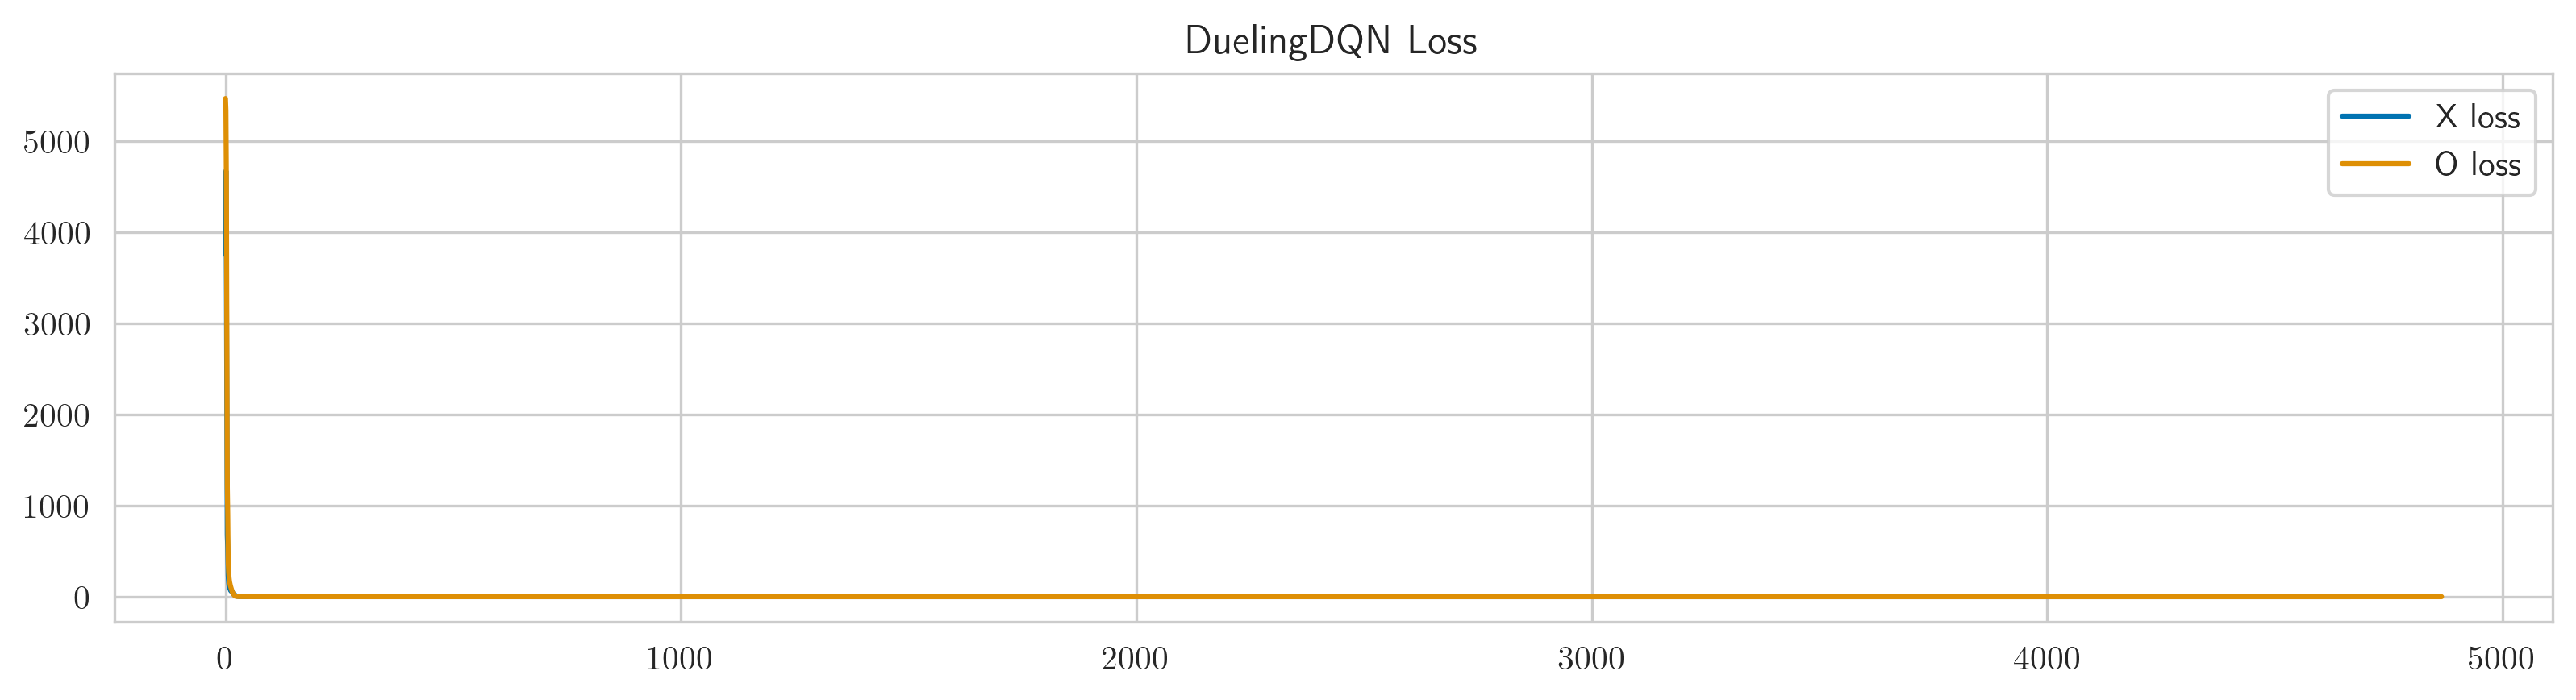

In [27]:
plt.figure(figsize=(13,3))       

plt.plot(piXd.loss[::10], label="X loss")
plt.plot(piOd.loss[::10], label="O loss")
plt.legend(loc="upper right")
plt.title("DuelingDQN Loss")
plt.show()

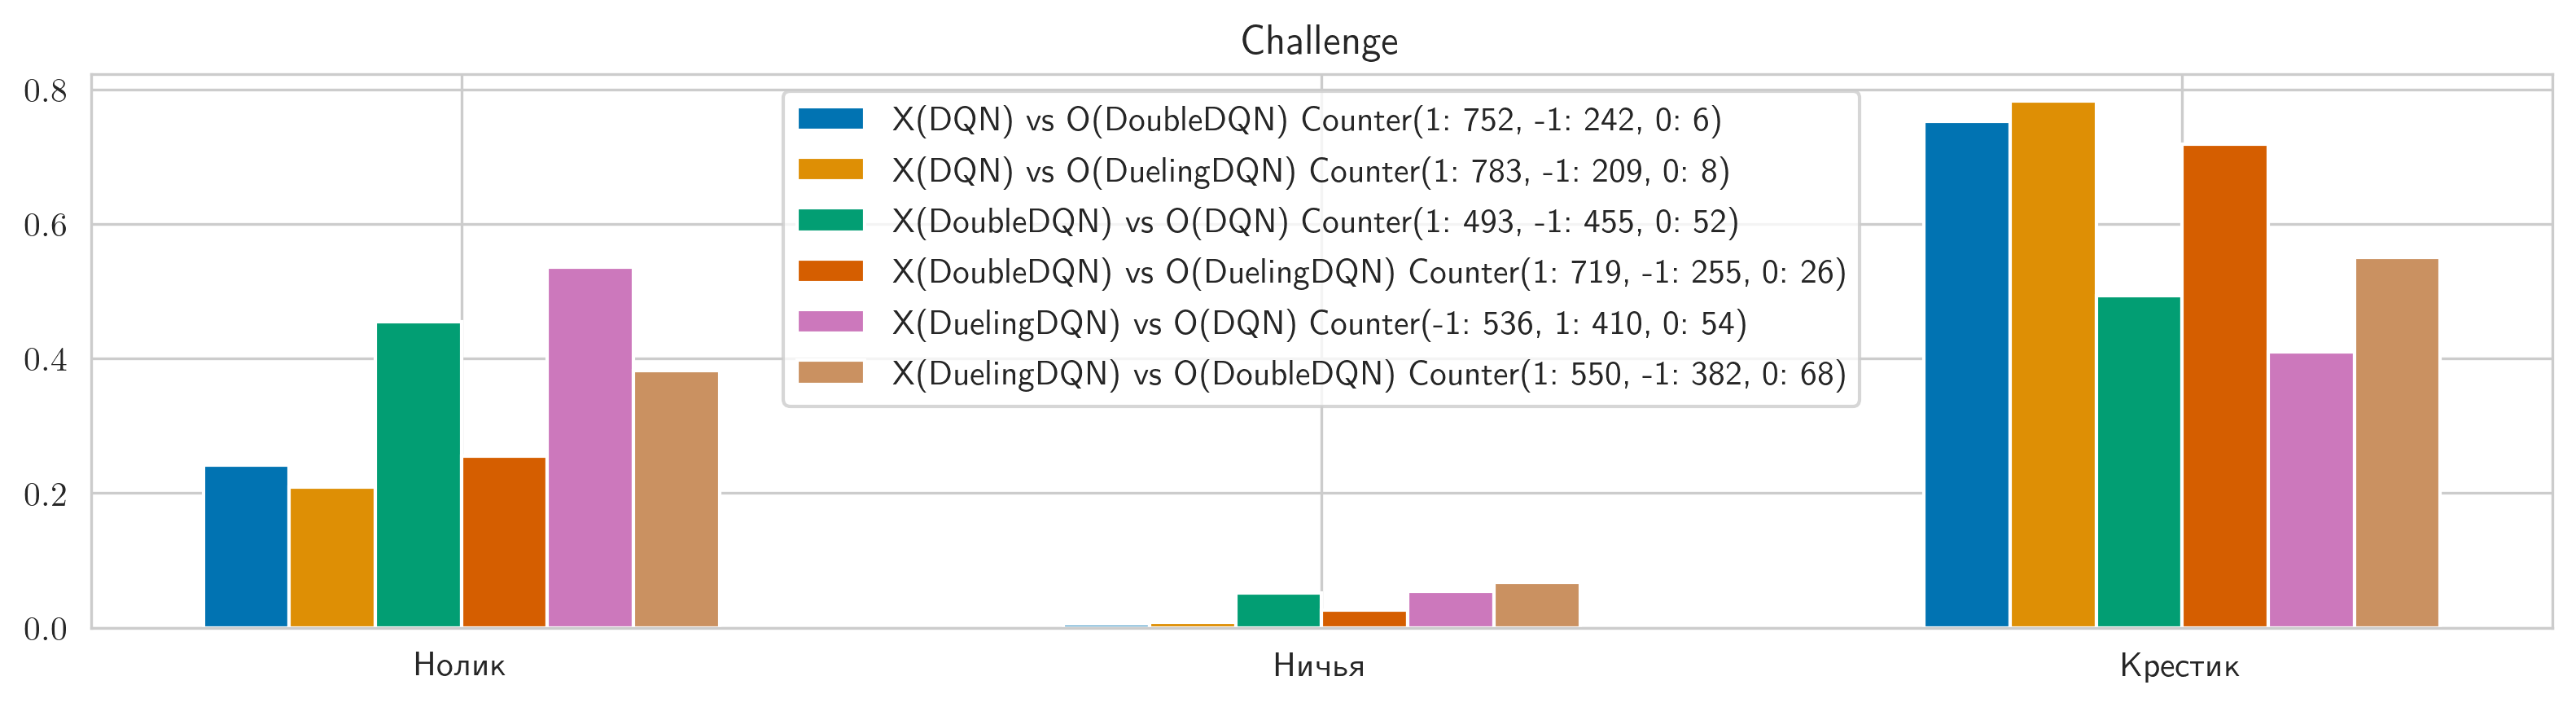

In [17]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piX, piO2)
plot_series_results(results-5/2*witdh, width=witdh, label=f"X(DQN) vs O(DoubleDQN) {Counter(results)}")

results = run_series(piX, piOd)
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(DQN) vs O(DuelingDQN) {Counter(results)}")

results = run_series(piX2, piO)
plot_series_results(results-1/2*witdh, width=witdh, label=f"X(DoubleDQN) vs O(DQN) {Counter(results)}")

results = run_series(piX2, piOd)
plot_series_results(results+1/2*witdh, width=witdh, label=f"X(DoubleDQN) vs O(DuelingDQN) {Counter(results)}")

results = run_series(piXd, piO)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(DuelingDQN) vs O(DQN) {Counter(results)}")

results = run_series(piXd, piO2)
plot_series_results(results+5/2*witdh, width=witdh, label=f"X(DuelingDQN) vs O(DoubleDQN) {Counter(results)}")

plt.legend(loc="upper center")
plt.title("Challenge")
plt.show()

# Выводы

- DQN модель обучилась и играет хорошо
- DobuleDQN и DuelingDQN играют хуже, надо настраивать параметры
- по сравнению с табличным Q-Learning результаты хуже
- думаю, что для данной задачи (дискретные состояния и действия, небольшая размерность) лучше подходит обычный табличный Q-Learning, потенциал сложных архитектур DobuleDQN и DuelingDQN не раскрыт